In [1]:
from itertools import islice, permutations, product
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython.display as display

from tensorflow.contrib.layers import fully_connected, flatten

from magnolia.features.mixer import FeatureMixer
from magnolia.features.wav_iterator import batcher
from magnolia.utils.tf_bits import scope

%matplotlib inline

In [2]:
num_srcs = 2
num_steps = 51
num_freq_bins = 257
batch_size = 64

    
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def scale_spectrogram(spectrogram):
    mag_spec = np.abs(spectrogram)
    phases = np.unwrap(np.angle(spectrogram))
    
    mag_spec = np.sqrt(mag_spec)
    M = mag_spec.max()
    m = mag_spec.min()
    
    return (mag_spec - m)/(M - m), phases

In [3]:
class PITModel:
    def __init__(self, X_in, y_in, num_srcs=2, num_steps=50, num_freq_bins=513):
        self.X_in = X_in
        self.y_in = y_in
        self.num_steps = num_steps
        self.num_freq_bins = num_freq_bins
        self.num_srcs = num_srcs
        
        self.dense
        self.dense_mask
        self.cnn_mask
        self.predict
        self.loss
        self.optimize     
        
    @scope
    def loss(self):
        '''
        Compute PIT loss across all examples in a minibatch,
        respecting that each example in the minibatch might 
        have a different optimal mapping of truth to reconstruction
        
        '''
        
        # compute pairwise costs
        # in 2-src case: either 1->2,2->1 or 1->1,2->2
        losses = []
        for src_id, out_id in product(range(self.num_srcs), range(self.num_srcs)):
            loss = tf.reduce_mean(tf.squared_difference(self.predict[:, out_id],
                                                        self.y_in[:, src_id]),
                                 axis=(1, 2))
            losses.append(loss)
            
        # for each *permutation* of src->output assignments, look up the 
        # appropriate losses and sum
        permuted_losses = []
        for assignment in permutations(range(self.num_srcs), self.num_srcs):
            permuted_loss = []
            for src_id, out_id in enumerate(assignment):
                loss_idx = src_id * self.num_srcs + out_id
                permuted_loss.append(losses[loss_idx])
            # sum losses over assigned pairings and add to list of permuted losses 
            permuted_loss = tf.stack(permuted_loss, axis=1)
            print(permuted_loss)
            permuted_loss = tf.reduce_sum(permuted_loss, axis=1)
            print(permuted_loss)
            permuted_losses.append(permuted_loss)
            
        # select the minimum loss across assignment permutations
        permuted_losses = tf.stack(permuted_losses,axis=1)
        print(permuted_losses)
        cost = tf.reduce_min(permuted_losses,axis=1)
        print(cost)
        cost = tf.reduce_sum(cost)
        print(cost)
        return cost
        
    @scope
    def optimize(self):
        optimizer = tf.train.AdamOptimizer()
        return optimizer.minimize(self.loss)
        
    @scope
    def predict(self):
        return self.dense_mask
    
    @scope
    def dense(self):
        data_shape = tf.shape(self.X_in)
        # Reduce dimensionality
        x = flatten(self.X_in)
        x = fully_connected(x, 1000)
        
        # Split into two branches
        y = fully_connected(x, 500)
        z = fully_connected(x, 500)
        
        # Reconstruct
        y = fully_connected(y, self.num_steps*self.num_freq_bins, None)
        y = tf.reshape(y, data_shape)
        
        z = fully_connected(z, self.num_steps*self.num_freq_bins, None)
        z = tf.reshape(z, data_shape)
        
        return tf.stack((y,z), axis=1)
    
    @scope
    def dense_mask(self):
        # Reduce dimensionality
        x = flatten(self.X_in)
        x = fully_connected(x, 1024)
        x = fully_connected(x, 1024)
        x = fully_connected(x, 1024)
        return self.mask_ops(x, x)
    
    def mask_ops(self, y, z):
        # Predict mask
        y_mask = fully_connected(y, self.num_steps*self.num_freq_bins, None)
        z_mask = fully_connected(z, self.num_steps*self.num_freq_bins, None)
        all_masks = tf.stack((y_mask, z_mask), axis=0)
        all_masks = tf.nn.softmax(all_masks, dim=0)
        all_masks = tf.reshape(all_masks, (2, -1, self.num_steps, self.num_freq_bins))
        
        # Reconstruct
        reconstructions = all_masks * self.X_in
        reconstructions = tf.transpose(reconstructions, [1, 0, 2, 3])
        
        return reconstructions
    
    @scope
    def cnn_mask(self):
        x = tf.reshape(self.X_in, (-1, self.num_steps, self.num_freq_bins, 1))
        x = tf.layers.conv2d(x, 64, kernel_size=(3, 3), strides=(2,2), 
                             name='conv1', padding='SAME', activation=tf.nn.relu)
        x = tf.layers.conv2d(x, 64, kernel_size=(3, 3), strides=(1,1), 
                             name='conv2', padding='SAME', activation=tf.nn.relu)
        x = tf.layers.conv2d(x, 64, kernel_size=(3, 3), strides=(1,1), 
                             name='conv3', padding='SAME', activation=tf.nn.relu)
        x = tf.layers.conv2d(x, 64, kernel_size=(3, 3), strides=(1,1), 
                             name='conv4', padding='SAME', activation=tf.nn.relu)
        x = tf.layers.conv2d(x, 64, kernel_size=(3, 3), strides=(1,1), 
                             name='conv5', padding='SAME', activation=tf.nn.relu)
        x = tf.layers.conv2d(x, 128, kernel_size=(3, 3), strides=(2,2), 
                             name='conv6', padding='SAME', activation=tf.nn.relu)
        x = tf.layers.conv2d(x, 128, kernel_size=(3, 3), strides=(1,1), 
                             name='conv7', padding='SAME', activation=tf.nn.relu)
        x = tf.layers.conv2d(x, 128, kernel_size=(3, 3), strides=(1,1), 
                             name='conv8', padding='SAME', activation=tf.nn.relu)
        x = tf.layers.conv2d(x, 256, kernel_size=(3, 3), strides=(2,2), 
                             name='conv9', padding='SAME', activation=tf.nn.relu)
        x = tf.layers.conv2d(x, 256, kernel_size=(3, 3), strides=(1,1), 
                             name='conv10', padding='SAME', activation=tf.nn.relu)
        x = tf.layers.conv2d(x, 256, kernel_size=(3, 3), strides=(1,1), 
                             name='conv11', padding='SAME', activation=tf.nn.relu)
        x = tf.nn.max_pool(x, ksize=[1,3,3,1], strides=[1,3,3,1], padding='SAME', name='maxpool11')
        x = flatten(x)
        x = tf.layers.dense(x, 1024, activation=tf.nn.relu, name='dense12')
        
        return self.mask_ops(x, x)
    
    @scope
    def blstm_mask(self):
        
        x = flatten(self.X_in)
        
        fwd_lstm = tf.contrib.rnn.BasicLSTMCell(896)
        
        x = tf.nn.bidirectional_dynamic_rnn()
        return self.mask_ops(x, x)

In [ ]:
tf.reset_default_graph()

features = tf.placeholder(tf.float32, (None, num_steps, num_freq_bins))
references = tf.placeholder(tf.float32, (None, 2, num_steps, num_freq_bins))

model = PITModel(features, references, num_srcs, num_steps, num_freq_bins)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

losses = []

Tensor("loss/stack:0", shape=(?, 2), dtype=float32)
Tensor("loss/Sum:0", shape=(?,), dtype=float32)
Tensor("loss/stack_1:0", shape=(?, 2), dtype=float32)
Tensor("loss/Sum_1:0", shape=(?,), dtype=float32)
Tensor("loss/stack_2:0", shape=(?, 2), dtype=float32)
Tensor("loss/Min:0", shape=(?,), dtype=float32)
Tensor("loss/Sum_2:0", shape=(), dtype=float32)


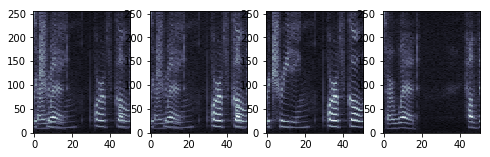

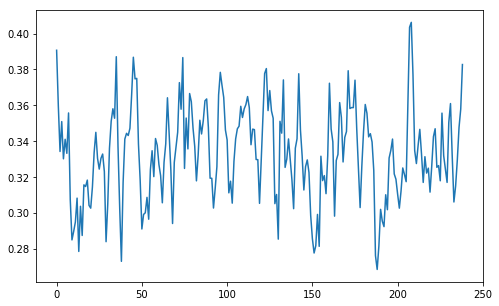

In [ ]:
librispeech_dev = "/local_data/teams/magnolia/librispeech/processed_dev-clean.h5"
librispeech_train = "/local_data/teams/magnolia/librispeech/processed_train-clean-100.h5"

mixed_features = FeatureMixer([librispeech_dev, librispeech_dev], shape=(num_steps, None))
data_batches = batcher(mixed_features, batch_size)

for i, batch in enumerate(islice(data_batches, 100000)):
    batch_features, batch_ref1, batch_ref2 = batch
    batch_ref1_norm, batch_ref1_norm_phase = scale_spectrogram(batch_ref1) 
    batch_ref2_norm, batch_ref2_norm_phase = scale_spectrogram(batch_ref2)
    batch_features_norm, batch_features_norm_phase = scale_spectrogram(batch_features)
    data = { 
        features: batch_features_norm,
        references: np.stack((batch_ref1_norm, batch_ref2_norm), axis=1)
        }
    sess.run(model.optimize, feed_dict=data)
    loss = sess.run(model.loss, feed_dict=data)
    losses.append(loss)
    prediction = sess.run(model.predict, data)
    
    if i % 10 == 0:
        display.clear_output(wait=True)
        plt.figure(figsize=(8,5))
        plt.subplot(1,4,1); plt.imshow(np.sqrt(prediction[0,0].T), cmap='bone', origin='lower', aspect=0.25)
        plt.subplot(1,4,2); plt.imshow(np.sqrt(prediction[0,1].T), cmap='bone', origin='lower', aspect=0.25)
        plt.subplot(1,4,3); plt.imshow(np.sqrt(batch_ref1_norm[0].T), cmap='bone', origin='lower', aspect=0.25)
        plt.subplot(1,4,4); plt.imshow(np.sqrt(batch_ref2_norm[0].T), cmap='bone', origin='lower', aspect=0.25)
        plt.figure(figsize=(8,5))
        plt.plot(moving_average(losses, 15))
        plt.show()
    

In [18]:
sess.run(tf.zeros((10,))[[0,1]])

ValueError: Index out of range using input dim 1; input has only 1 dims for 'strided_slice_3' (op: 'StridedSlice') with input shapes: [10], [2], [2], [2].